# MUX 4/1 - SSA

In [15]:
def simulate_stochastic_clb(params, Y0, Omega, T_end, dt = 1): 
    state = np.array(Y0)
        
    Y_total = np.zeros([1 + T_end//dt, len(state)])
    T = np.zeros(1 + T_end//dt)
    t = 0 

    Y_total[0, :] = state
    T[0] = t
   
    N = CLB_generate_stoichiometry()

    i = 1
    last_time = t

    while t < T_end: 
        if t > T_end/2:
            params[-8:] = 0, 0, 0, 0, 0, 0, 0, 0

        #choose two random numbers 
        r = np.random.uniform(size=2)
        r1 = r[0]
        r2 = r[1]           

        a = CLB_model_stochastic(state, params, Omega)

        asum = np.cumsum(a)
        a0 = np.sum(a)  
        #get tau
        tau = (1.0/a0)*np.log(1.0/r1)    

        #select reaction 
        reaction_number = np.argwhere(asum > r2*a0)[0,0] #get first element         
        
        #update concentrations
        state = state + N[:,reaction_number]      
        
        #update time
        t = t + tau  

        if (t - last_time >= dt) or (t >= T_end):
            last_time = t
            Y_total[i, :] = state
            T[i] = t                
            i += 1
    
    return T[:i], Y_total[:i,:]

([0, 0], [0, 0, 0, 0])
([0, 0], [1, 0, 0, 0])
([1, 0], [1, 0, 0, 0])
([1, 0], [0, 1, 0, 0])
([0, 1], [0, 1, 0, 0])
([0, 1], [0, 0, 1, 0])
([1, 1], [0, 0, 1, 0])
([1, 1], [0, 0, 0, 1])
Duration: 0:05:12.217373


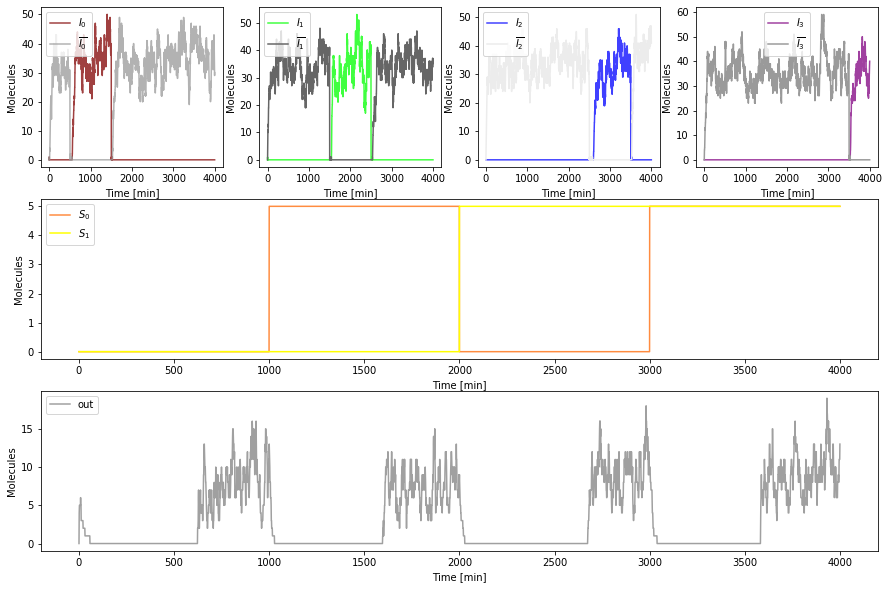

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from parameters import *
from models import *
from datetime import datetime

start_time = datetime.now()

Y0 = np.zeros(59)
# number of cells: toggle switches
N_I0 = np.array([1,1])
N_I1 = np.array([1,1])
N_I2 = np.array([1,1])
N_I3 = np.array([1,1])

Y0[4:6] = N_I0
Y0[10:12] = N_I1
Y0[16:18] = N_I2
Y0[22:24] = N_I3

# number of cells: mux
#Y0[22-4+24:38-4+24] = 1 # number of cells
Y0[42:58] = 1 # number of cells


# N_cells should be set to 1
Omega = 5

t_end = 500


states = [([0,0], [0,0,0,0]), 
          ([0,0], [1,0,0,0]), 
          ([1,0], [1,0,0,0]),
          ([1,0], [0,1,0,0]), 
          ([0,1], [0,1,0,0]),
          ([0,1], [0,0,1,0]), 
          ([1,1], [0,0,1,0]), 
          ([1,1], [0,0,0,1])]
"""
states = [([0,0], [0,0,0,0]), ([0,0], [1,0,0,0]), 
          ([1,0], [1,0,0,0]), ([1,0], [1,1,0,0]), 
          ([0,1], [1,1,0,0]), ([0,1], [1,1,1,0]), 
          ([1,1], [1,1,1,0]), ([1,1], [1,1,1,1])]
"""

for iteration, state in enumerate(states):
    print(state)
    S = state[0]
    I = state[1]
    I0, I1, I2, I3 = I

    rho_x = 0
    rho_y = 0
    
    
    if iteration > 0 and states[iteration-1][1] == I:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = 0, 0, 0, 0, 0, 0, 0, 0        
    else:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = (1-I0) * 5, I0*5, (1-I1)*5, I1*5, (1-I2)*5, I2*5, (1-I3)*5, I3*5
    
    params = [delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b]
    
        

    if iteration:
        Y0 = Y_full[-1,:]

    #print(Y0)

    Y0[24:26] = np.array(S) * Omega

    T, Y = simulate_stochastic_clb(params, Y0, Omega, t_end)

    if not iteration:
        Y_full = Y
        T_full = T
    else:        
        Y_full = np.append(Y_full, Y, axis = 0)
        T_full = np.append(T_full, T + T_full[-1], axis = 0)

Y = Y_full
T = T_full

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


"""
results
"""


out = Y[:,-1]

S0, S1 = Y[:,24], Y[:,25]

I0_a, I0_b = Y[:,2], Y[:,3]
I1_a, I1_b = Y[:,8], Y[:,9]
I2_a, I2_b = Y[:,14], Y[:,15]
I3_a, I3_b = Y[:,20], Y[:,21]

# plot
ax1 = plt.subplot(341)
ax1.plot(T, I0_a, color="#800000ff", alpha=0.75)
ax1.plot(T, I0_b, color="#999999ff", alpha=0.75)
ax1.legend(["$I_0$", "$\\overline{I_0}$"])
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Molecules")


ax2 = plt.subplot(342)
ax2.plot(T, I1_a, color = "#00ff00ff", alpha=0.75)
ax2.plot(T, I1_b, color = "#666666ff")#, alpha=0.75)
ax2.legend(["$I_1$", "$\\overline{I_1}$"])
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Molecules")


ax3 = plt.subplot(343)
ax3.plot(T, I2_a, color = "#0000ffff", alpha=0.75)
ax3.plot(T, I2_b, color = "#ecececfe")#, alpha=0.75)
ax3.legend(["$I_2$", "$\\overline{I_2}$"])
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Molecules")


ax4 = plt.subplot(344)
ax4.plot(T, I3_a, color = "#800080ff", alpha=0.75)
ax4.plot(T, I3_b, color = "#999999fc")#, alpha=0.75)
ax4.legend(["$I_3$", "$\\overline{I_3}$"])
ax4.set_xlabel("Time [min]")
ax4.set_ylabel("Molecules")


ax5 = plt.subplot(312)
ax5.plot(T,S0, color = "#ff6600ff", alpha=0.75)
ax5.plot(T,S1, color = "#ffff00ff")#, alpha=0.75)
ax5.legend(["$S_0$", "$S_1$"])
ax5.set_xlabel("Time [min]")
ax5.set_ylabel("Molecules")


ax6 = plt.subplot(313)
ax6.plot(T,out, color = "#8080805a", alpha=0.75)
ax6.legend(['out'])
ax6.set_xlabel("Time [min]")
ax6.set_ylabel("Molecules")

plt.gcf().set_size_inches(15,10)
#plt.savefig("figs/CBLB_ssa.pdf", bbox_inches = 'tight')
plt.show()

# MUX 8/1 - SSA

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from parameters import *
from models_8bit_cblb import *

def simulate_stochastic_clb_8(params, Y0, Omega, T_end, dt = 1): 
    state = np.array(Y0)
        
    Y_total = np.zeros([1+T_end//dt, len(state)])
    T = np.zeros(1+T_end//dt)
    t = 0 

    Y_total[0, :] = state
    T[0] = t
   
    N = CLB_8_generate_stoichiometry()

    i = 1
    last_time = t

    while t < T_end: 
        if t > T_end/2:
            #params[-8:] = rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b
            params[-16:] = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

        #choose two random numbers 
        r = np.random.uniform(size=2)
        r1 = r[0]
        r2 = r[1]           
        
        a = CLB_8_model_stohastic(state, params, Omega)

        asum = np.cumsum(a)
        a0 = np.sum(a)
        #get tau
        tau = (1.0/a0)*np.log(1.0/r1)    
       
        #select reaction
        reaction_number = np.argwhere(asum > r2*a0)[0,0] #get first element         
        
        #update concentrations  
        state = state + N[:,reaction_number]
            
        #update time
        t = t + tau

        if (t - last_time >= dt) or (t >= T_end):
            last_time = t
            Y_total[i, :] = state
            T[i] = t                
            i += 1
    return T[:i], Y_total[:i,:]

0.15 0.495 1.2 0.167 0.162 1550 2 0.023 0.023 5 5 0.495 0.167 0.07 0.07


([0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0])
([0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0])
([0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0])
([0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 0])
([0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0])
([0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 0])
([0, 1, 1], [0, 0, 1, 0, 0, 0, 0, 0])
([0, 1, 1], [0, 0, 0, 1, 0, 0, 0, 0])
([1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0])
([1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0])
([1, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0])
([1, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0])
([1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0])
([1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 0])
([1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 0])
([1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1])
Duration: 2:01:37.969075


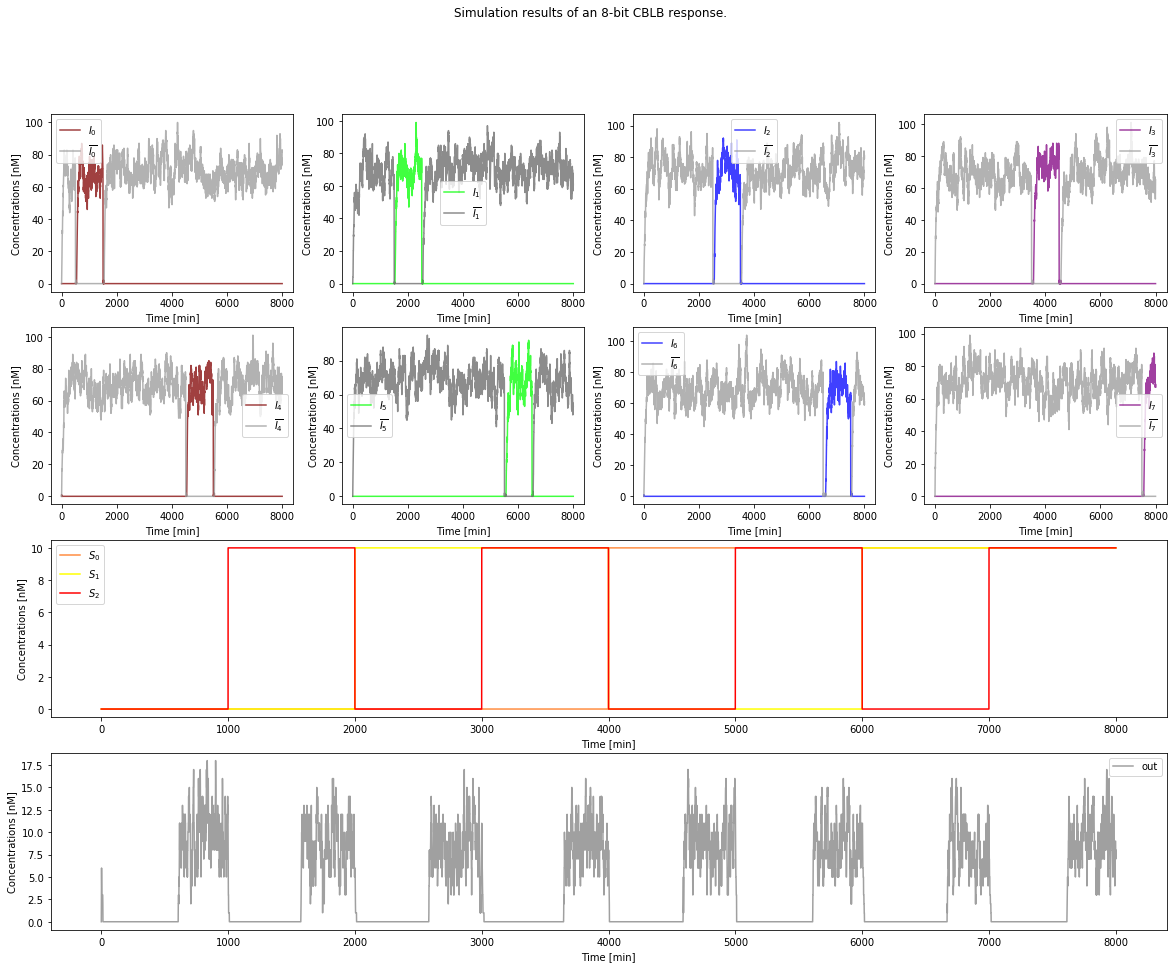

In [2]:
from datetime import datetime

start_time = datetime.now()

Y0 = np.zeros(128)

# number of cells: toggle switches
N_I0 = np.array([1,1])
N_I1 = np.array([1,1])
N_I2 = np.array([1,1])
N_I3 = np.array([1,1])
N_I4 = np.array([1,1])
N_I5 = np.array([1,1])
N_I6 = np.array([1,1])
N_I7 = np.array([1,1])

Y0[4:6] = N_I0
Y0[10:12] = N_I1
Y0[16:18] = N_I2
Y0[22:24] = N_I3
Y0[28:30] = N_I4
Y0[34:36] = N_I5
Y0[40:42] = N_I6
Y0[46:48] = N_I7

# number of cells: mux 8/1 = 40
Y0[87:127] = 1 # number of cells


# reaction space volume for the whole cell population
# N_cells should be set to 1
Omega = 10

t_end = 500


states = [([0,0,0], [0,0,0,0,0,0,0,0]), 
          ([0,0,0], [1,0,0,0,0,0,0,0]), 
          ([0,0,1], [1,0,0,0,0,0,0,0]),
          ([0,0,1], [0,1,0,0,0,0,0,0]), 
          ([0,1,0], [0,1,0,0,0,0,0,0]),
          ([0,1,0], [0,0,1,0,0,0,0,0]),
          ([0,1,1], [0,0,1,0,0,0,0,0]), 
          ([0,1,1], [0,0,0,1,0,0,0,0]),
          ([1,0,0], [0,0,0,1,0,0,0,0]),
          ([1,0,0], [0,0,0,0,1,0,0,0]),
          ([1,0,1], [0,0,0,0,1,0,0,0]),
          ([1,0,1], [0,0,0,0,0,1,0,0]),
          ([1,1,0], [0,0,0,0,0,1,0,0]),
          ([1,1,0], [0,0,0,0,0,0,1,0]),
          ([1,1,1], [0,0,0,0,0,0,1,0]),
          ([1,1,1], [0,0,0,0,0,0,0,1])]

for iteration, state in enumerate(states):
    print(state)
    S = state[0]
    I = state[1]
    I0, I1, I2, I3, I4, I5, I6, I7 = I

    rho_x = 0
    rho_y = 0
    
    
    if iteration > 0 and states[iteration-1][1] == I:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = 0, 0, 0, 0, 0, 0, 0, 0
        rho_I4_a, rho_I4_b, rho_I5_a, rho_I5_b, rho_I6_a, rho_I6_b, rho_I7_a, rho_I7_b = 0, 0, 0, 0, 0, 0, 0, 0      
    else:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = (1-I0)*5, I0*5, (1-I1)*5, I1*5, (1-I2)*5, I2*5, (1-I3)*5, I3*5
        rho_I4_a, rho_I4_b, rho_I5_a, rho_I5_b, rho_I6_a, rho_I6_b, rho_I7_a, rho_I7_b = (1-I4)*5, I4*5, (1-I5)*5, I5*5, (1-I6)*5, I6*5, (1-I7)*5, I7*5
    
    params = [delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b, rho_I4_a, rho_I4_b, rho_I5_a, rho_I5_b, rho_I6_a, rho_I6_b, rho_I7_a, rho_I7_b]
    
        

    if iteration:
        Y0 = Y_full[-1,:]

    Y0[48:51] = np.array(S) * Omega
    T, Y = simulate_stochastic_clb_8(params, Y0, Omega, t_end)

    if not iteration:
        Y_full = Y
        T_full = T
    else:        
        Y_full = np.append(Y_full, Y, axis = 0)
        T_full = np.append(T_full, T + T_full[-1], axis = 0)

Y = Y_full
T = T_full

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


"""
results
"""
out = Y[:,-1]
S0, S1, S2 = Y[:,48], Y[:,49], Y[:,50]
I0_a, I0_b = Y[:,2], Y[:,3]
I1_a, I1_b = Y[:,8], Y[:,9]
I2_a, I2_b = Y[:,14], Y[:,15]
I3_a, I3_b = Y[:,20], Y[:,21]
I4_a, I4_b = Y[:,26], Y[:,27]
I5_a, I5_b = Y[:,32], Y[:,33]
I6_a, I6_b = Y[:,38], Y[:,39]
I7_a, I7_b = Y[:,44], Y[:,45]

# plot
fig = plt.figure()
fig.suptitle("Simulation results of an 8-bit CBLB response.")
ax1 = fig.add_subplot(4,4,1)
ax1.plot(T, I0_a, color="#800000ff", alpha=0.75)
ax1.plot(T, I0_b, color="#999999ff", alpha=0.75)
ax1.legend(["$I_0$", "$\\overline{I_0}$"])
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Concentrations [nM]")

ax2 = fig.add_subplot(4,4,2)
ax2.plot(T, I1_a, color = "#00ff00ff", alpha=0.75)
ax2.plot(T, I1_b, color = "#666666ff", alpha=0.75)
ax2.legend(["$I_1$", "$\\overline{I_1}$"])
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Concentrations [nM]")

ax3 = fig.add_subplot(4,4,3)
ax3.plot(T, I2_a, color = "#0000ffff", alpha=0.75)
ax3.plot(T, I2_b, color = "#999999ff", alpha=0.75)
ax3.legend(["$I_2$", "$\\overline{I_2}$"])
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Concentrations [nM]")

ax4 = fig.add_subplot(4,4,4)
ax4.plot(T, I3_a, color = "#800080ff", alpha=0.75)
ax4.plot(T, I3_b, color = "#999999fc", alpha=0.75)
ax4.legend(["$I_3$", "$\\overline{I_3}$"])
ax4.set_xlabel("Time [min]")
ax4.set_ylabel("Concentrations [nM]")

ax5 = fig.add_subplot(4,4,5)
ax5.plot(T, I4_a, color = "#800000ff", alpha=0.75)
ax5.plot(T, I4_b, color = "#999999ff", alpha=0.75)
ax5.legend(["$I_4$", "$\\overline{I_4}$"])
ax5.set_xlabel("Time [min]")
ax5.set_ylabel("Concentrations [nM]")

ax6 = fig.add_subplot(4,4,6)
ax6.plot(T, I5_a, color = "#00ff00ff", alpha=0.75)
ax6.plot(T, I5_b, color = "#666666ff", alpha=0.75)
ax6.legend(["$I_5$", "$\\overline{I_5}$"])
ax6.set_xlabel("Time [min]")
ax6.set_ylabel("Concentrations [nM]")

ax7 = fig.add_subplot(4,4,7)
ax7.plot(T, I6_a, color = "#0000ffff", alpha=0.75)
ax7.plot(T, I6_b, color = "#999999ff", alpha=0.75)
ax7.legend(["$I_6$", "$\\overline{I_6}$"])
ax7.set_xlabel("Time [min]")
ax7.set_ylabel("Concentrations [nM]")

ax8 = fig.add_subplot(4,4,8)
ax8.plot(T, I7_a, color = "#800080ff", alpha=0.75)
ax8.plot(T, I7_b, color = "#999999fc", alpha=0.75)
ax8.legend(["$I_7$", "$\\overline{I_7}$"])
ax8.set_xlabel("Time [min]")
ax8.set_ylabel("Concentrations [nM]")

ax9 = fig.add_subplot(4,1,3)
ax9.plot(T,S0, color = "#ff6600ff", alpha=0.75)
ax9.plot(T,S1, color = "#ffff00ff")
ax9.plot(T,S2, color = "#ff0000ff")
ax9.legend(["$S_0$", "$S_1$", "$S_2$"])
ax9.set_xlabel("Time [min]")
ax9.set_ylabel("Concentrations [nM]")

ax10 = fig.add_subplot(4,1,4)
ax10.plot(T,out, color = "#8080805a", alpha=0.75)
ax10.legend(['out'])
ax10.set_xlabel("Time [min]")
ax10.set_ylabel("Concentrations [nM]")

plt.gcf().set_size_inches(20,15)
# plt.savefig("figs/CBLB_ssa_mux_8_1.pdf", bbox_inches = 'tight')

plt.show()

# MUX 2/1 - SSA

In [13]:
from models_2bit_cblb import *
import numpy as np
import matplotlib.pyplot as plt

from parameters import *
from models import *

def simulate_stochastic_clb_2(params, Y0, Omega, T_end, dt = 1): 
    state = np.array(Y0)
        
    Y_total = np.zeros([1 + T_end//dt, len(state)])
    T = np.zeros(1 + T_end//dt)
    t = 0 

    Y_total[0, :] = state
    T[0] = t
   
    N = CLB_2_generate_stoichiometry()

    i = 1
    last_time = t

    while t < T_end: 
        if t > T_end/2:
            params[-4:] = 0, 0, 0, 0

        #choose two random numbers 
        r = np.random.uniform(size=2)
        r1 = r[0]
        r2 = r[1]           

        a = CLB_2_model_stohastic(state, params, Omega)

        asum = np.cumsum(a)
        a0 = np.sum(a)  
        #get tau
        tau = (1.0/a0)*np.log(1.0/r1)    

        #select reaction 
        reaction_number = np.argwhere(asum > r2*a0)[0,0] #get first element         
        
        #update concentrations
        state = state + N[:,reaction_number]      
        
        #update time
        t = t + tau  

        if (t - last_time >= dt) or (t >= T_end):
            last_time = t
            Y_total[i, :] = state
            T[i] = t                
            i += 1
    
    return T[:i], Y_total[:i,:]

([0], [0, 0])
([0], [1, 0])
([1], [1, 0])
([1], [0, 1])
Duration: 0:00:51.550543


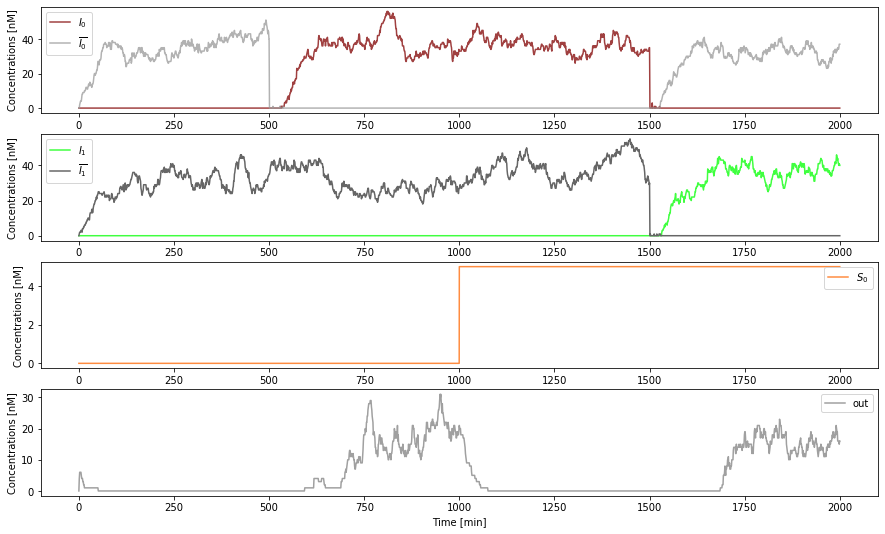

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from parameters import *
from models import *
from datetime import datetime

start_time = datetime.now()

Y0 = np.zeros(27)
# number of cells: toggle switches
N_I0 = np.array([1,1])
N_I1 = np.array([1,1])

Y0[4:6] = N_I0
Y0[10:12] = N_I1

# number of cells: mux
#Y0[22-4+24:38-4+24] = 1 # number of cells
Y0[20:26] = 1 # number of cells


# N_cells should be set to 1
Omega = 5

t_end = 500


states = [([0], [0,0]), 
          ([0], [1,0]), 
          ([1], [1,0]),
          ([1], [0,1])]

for iteration, state in enumerate(states):
    print(state)
    S = state[0]
    I = state[1]
    I0, I1 = I

    rho_x = 0
    rho_y = 0
    
    
    if iteration > 0 and states[iteration-1][1] == I:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b = 0, 0, 0, 0
    else:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b = (1-I0) * 5, I0*5, (1-I1)*5, I1*5
    
    params = [delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b]

    if iteration:
        Y0 = Y_full[-1,:]

    #print(Y0)

    Y0[12:13] = np.array(S) * Omega

    T, Y = simulate_stochastic_clb_2(params, Y0, Omega, t_end)

    if not iteration:
        Y_full = Y
        T_full = T
    else:        
        Y_full = np.append(Y_full, Y, axis = 0)
        T_full = np.append(T_full, T + T_full[-1], axis = 0)

Y = Y_full
T = T_full

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


"""
results
"""
out = Y[:,-1]

S0 = Y[:,12]
I0_a, I0_b = Y[:,2], Y[:,3]
I1_a, I1_b = Y[:,8], Y[:,9]

# plot
ax1 = plt.subplot(411)
ax1.plot(T, I0_a, color="#800000ff", alpha=0.75)
ax1.plot(T, I0_b, color="#999999ff", alpha=0.75)
ax1.legend(["$I_0$", "$\\overline{I_0}$"])
#ax1.set_title('$I_0$ toggle')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Concentrations [nM]")


ax2 = plt.subplot(412)
ax2.plot(T, I1_a, color = "#00ff00ff", alpha=0.75)
ax2.plot(T, I1_b, color = "#666666ff")#, alpha=0.75)
ax2.legend(["$I_1$", "$\\overline{I_1}$"])
#ax2.set_title('$I_1$ toggle')
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Concentrations [nM]")


ax3 = plt.subplot(413)
ax3.plot(T,S0, color = "#ff6600ff", alpha=0.75)
# ax5.plot(T,S1, color = "#ffff00ff")#, alpha=0.75)
ax3.legend(["$S_0$"])
#ax5.set_title('Select inputs')
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Concentrations [nM]")


ax4 = plt.subplot(414)
ax4.plot(T,out, color = "#8080805a", alpha=0.75)
#ax6.set_title('out')
ax4.legend(['out'])
ax4.set_xlabel("Time [min]")
ax4.set_ylabel("Concentrations [nM]")

plt.gcf().set_size_inches(15,9)
# plt.savefig("figs/CBLB_ssa_mux_2_1.pdf", bbox_inches = 'tight')

plt.show()